# Chapter4 DCGAN
- 합성곱 신경망의 주요개념 이해
- 배치 정규화 사용
- 고급 GAN구조인 심층 합성곱 싱경망을 구현

- 생산자와 판별자가 합성곱 신경망을 사용한다면 더 좋은 성능을 낸다
- Deep convolutional generative adversial network(DCGAN)
- DCGAN같은 복잡한 신경망 구조를 실전에 가능하게 만든 혁신중 하나인 배치 정규화가 사용된다.

## 4.1 합성곱 신경망
### 4.1.1 합성곱 필터
- 일반적인 피드포워드 신경망은 뉴런이 일렬로 놓여있고 층이 완전히 연결되어 있습니다.
- ConvNet의 층은 3차원으로 구성된다(너비 높이 깊이).
- 하나 이상의 필터가 입력층 위를 슬라이딩하면서 합성곱을 수행한다.
- 각 필터는 비교적 작은 수용장(receptive field)을 갖는다. 하지만 항상 입력 배열의 전체 깊이에 적용된다.
- 이 값은 일력과 필터사이의 점곱으로 계산한다.
- 필터마다 2차원 활성화 맵이 만들어진다.
- 각 필터가 만든 활성화 맵을 차례대로 

### 4.1.2 파라미터 공유
- 특정 필터의 파라미터가 모든 입력값에 공유된다는 점은 중요하다.
- 직관적이고 실용적인 장점이 있다.
- 파리미터 공유를 통해 시각적인 특징과 모양이 입력이미지의 어느 부분에 있는지에 효율적으로 학습할 수 있다.
- 


### 4.1.3 그림으로 ConvNet 이해하기
- 




## 4.2 DCGAN의 간략한 역사
- Alex Radford, Luke Metz, Soumith Chintala가 2016년에 소개한 DCGAN은 2년전 GAN이 시작된 이래 가장 중요한 혁신이다.
- ConvNet을 사용하면서 GAN훈련의 어려움은 가중되었다.
- 여기에는 불안정함과 그레디안트 포화(gradient saturation, 그레디언트가 너무 작아 학습이 느려지는 현상)가 포함된다.
- 이러한 문제 때문에 일부 연구자들이 LAPGAN같은 다른 방식을 사용하게 되었다. (LAPGAN,Laplacian pytamid 합성곱 신경망을 많이 쌓는것)각 단계에 있는 합성곱은 GAN프레임 워크를 사용해 독립적으로 훈련한다. 
- 그러나 DCGAN에 의해 역사속으로 사라졌다.
- 구조가 복잡하지않고 계산비용이 많이 들지만, LAPGAN은 그당시 가장 높은 품질의 이미지를 만들었다. 원본 GAN보다 4배나 성능이 높았다(생성된 이미지 중에 사람이 진짜 속은 비율이 10%에서 40%로 늘었다.)
- 그런 면에서 LAPGAN이 GAN와 ConvNet의 결합에 큰 잠재성을 보여주었다.
- 래드퍼드와 연구진들은 DCGAN에서 ConvNet을 사용해 완전한 GAN프레임워크의 스케일을 키울 수 있는 기법과 최적화 방법을 소개했다.
- 래드퍼드와 연구진이 이 사용한 핵심 기법 중 하나는 배치 졍규화이다.
- 배치 정규화는 각 층의 입력을 정규화하여 안정적으로 훈려나는 것을 도와준다.

## 4.3 배치정규화 (batch normalization
- 2015년 구글 연구원 Segey loffe, Chritian Szegedy가 소개했다.
- 신경망의 입력을 정규화하기 때문에 신경망을 통과하는 훈련 미니배치를 위해 각 층의 입력을 정규화하자고 제안했다.


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
img_rows = 28
img_cols = 28
channels = 1

# 입력 이미지 차원
img_shape = (img_rows, img_cols, channels)

# 생성자 입력으로 사용될 잡음 벡터의 크기
z_dim = 100

def build_generator(z_dim):
    
    model = Sequential()

    # 완전 연결층을 통해 입력을 7x7x256 크기 텐서로 변환
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # 7x7x256에서 14x14x128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x128에서 14x14x64 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # 배치 정규화
    model.add(BatchNormalization())

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x64에서 28x28x1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # tanh 활성화 함수를 사용한 출력층
    model.add(Activation('tanh'))

    return model


def build_discriminator(img_shape):
    
    model = Sequential()

    # 28x28x1에서 14x14x32 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 14x14x32에서 7x7x64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))

    # 7x7x64에서 3x3x128 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))
    
    # sigmoid 활성화 함수를 사용한 출력층
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [5]:
def build_gan(generator, discriminator):
    
    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model

    # 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

2022-06-22 01:09:57.737424: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-22 01:09:57.737563: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [6]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 생성된 이미지 샘플 출력
            sample_images(generator)
            

In [7]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    
    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    

2022-06-22 01:10:01.765165: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-22 01:10:01.804157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-22 01:10:02.290730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-22 01:10:03.466575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000 [D 손실: 0.422558, 정확도: 80.08%] [G 손실: 1.664709]


2022-06-22 01:11:50.962541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


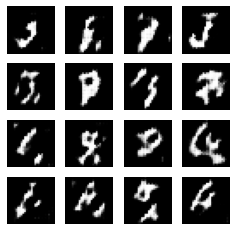

2000 [D 손실: 0.504849, 정확도: 75.78%] [G 손실: 1.552743]


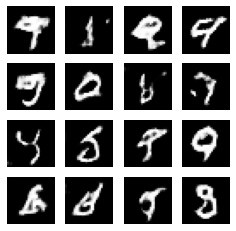

3000 [D 손실: 0.483236, 정확도: 77.34%] [G 손실: 1.706358]


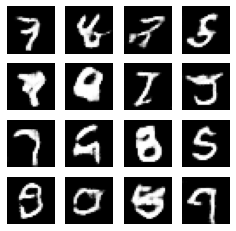

4000 [D 손실: 0.448781, 정확도: 80.47%] [G 손실: 1.700250]


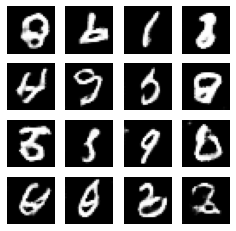

5000 [D 손실: 0.480219, 정확도: 78.12%] [G 손실: 2.047793]


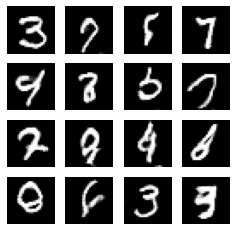

6000 [D 손실: 0.398204, 정확도: 84.38%] [G 손실: 2.104430]


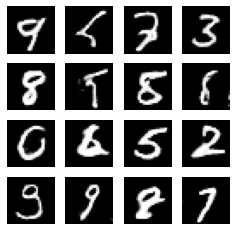

7000 [D 손실: 0.413481, 정확도: 78.91%] [G 손실: 2.109281]


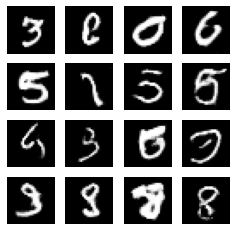

8000 [D 손실: 0.415072, 정확도: 80.08%] [G 손실: 1.883783]


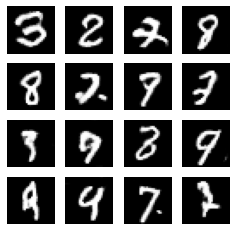

9000 [D 손실: 0.373081, 정확도: 83.20%] [G 손실: 2.158262]


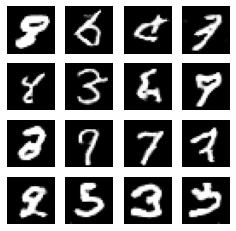

10000 [D 손실: 0.389193, 정확도: 80.86%] [G 손실: 2.353785]


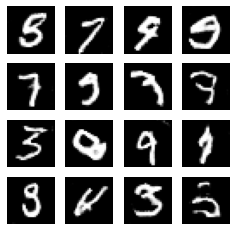

11000 [D 손실: 0.345048, 정확도: 85.94%] [G 손실: 2.023457]


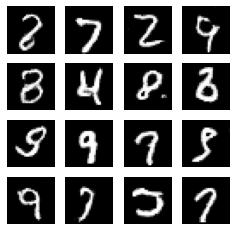

12000 [D 손실: 0.420709, 정확도: 80.86%] [G 손실: 2.324159]


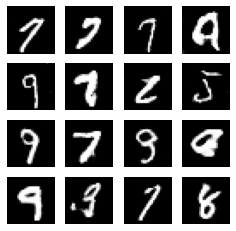

13000 [D 손실: 0.388873, 정확도: 82.42%] [G 손실: 2.118642]


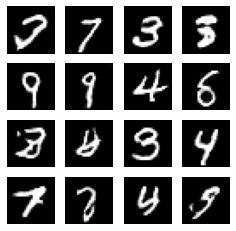

14000 [D 손실: 0.375000, 정확도: 81.64%] [G 손실: 1.753602]


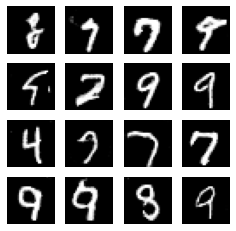

15000 [D 손실: 0.380376, 정확도: 78.52%] [G 손실: 2.161843]


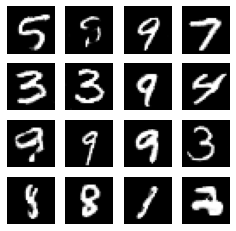

16000 [D 손실: 0.445649, 정확도: 80.47%] [G 손실: 1.975483]


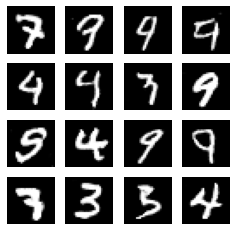

17000 [D 손실: 0.328596, 정확도: 85.55%] [G 손실: 2.129071]


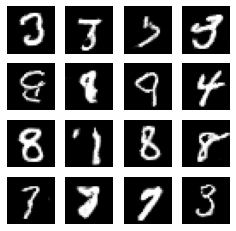

18000 [D 손실: 0.329430, 정확도: 84.38%] [G 손실: 2.311008]


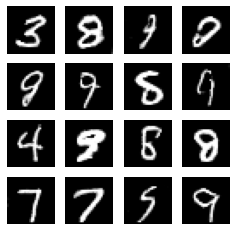

19000 [D 손실: 0.374572, 정확도: 81.25%] [G 손실: 1.822916]


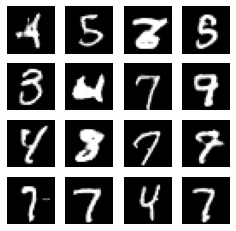

20000 [D 손실: 0.306429, 정확도: 85.55%] [G 손실: 2.934298]


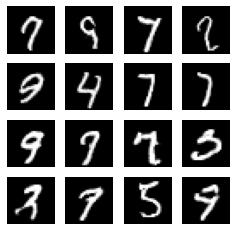

In [8]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련
train(iterations, batch_size, sample_interval)



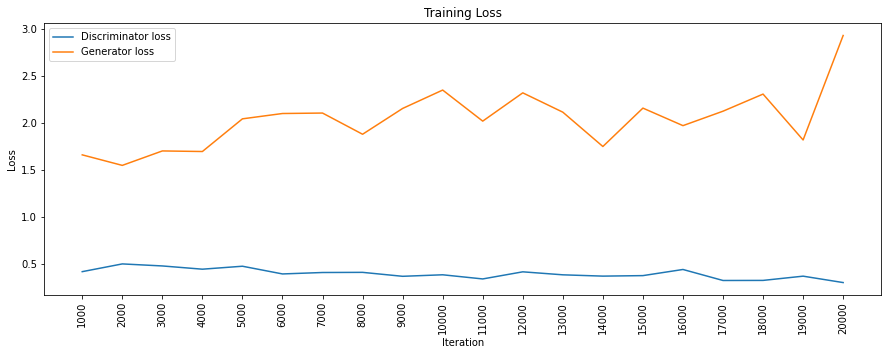

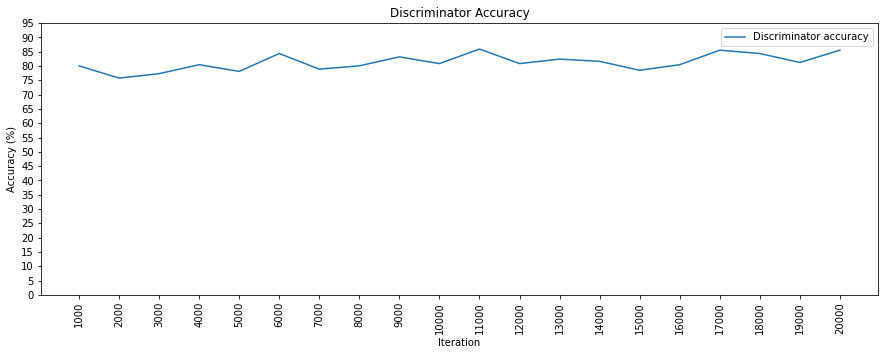

In [9]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()
